In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.backends.mps as mps 
import copy
import time
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Configuration

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on device: {device}")

Running on device: cuda


# Load Datasets

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

batch_size = 64
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# LeNet

In [5]:
def resnet18():
    model = models.resnet18(weights=None)  # Use pretrained=True if desired
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    model.maxpool = nn.Identity()
    model.fc = nn.Linear(512, 10)  # CIFAR-10 has 10 classes
    return model

# Evaluate

In [6]:
def evaluate_model(model, dataloader):
    correct, total = 0, 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total  # Accuracy in %

In [7]:
def compute_communication_efficiency(final_accuracy, sync_steps):
    return final_accuracy / sync_steps if sync_steps > 0 else final_accuracy


In [8]:
def measure_communication_cost(model, compression_factor=1.0):
    total_size = 0
    for param in model.parameters():
        if param.grad is not None:
            param_size = param.grad.numel() * param.grad.element_size()  # Size in bytes
            total_size += param_size * compression_factor
    return total_size / (1024 * 1024)  # Convert to MB

# AGC Function

In [9]:
def apply_agc_quantization(model, num_bits=8):
    scale = 2 ** num_bits - 1
    for param in model.parameters():
        if param.grad is not None:
            grad = param.grad
            min_val, max_val = grad.min(), grad.max()
            grad = (grad - min_val) / (max_val - min_val) * scale
            grad = torch.round(grad) / scale * (max_val - min_val) + min_val
            param.grad = grad

# Training function

In [10]:
def train_baseline(model, epochs=10):
    model = copy.deepcopy(model).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_history = []
    accuracy_history = []
    communication_cost_history = []
    
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        avg_loss = running_loss / len(trainloader)
        loss_history.append(avg_loss)
        accuracy_history.append(evaluate_model(model, testloader))
        communication_cost = measure_communication_cost(model)
        communication_cost_history.append(communication_cost)
        print("Epoch %d: Loss = %.4f, Accuracy = %.2f%%, Communication Cost: %.4f MB" % (epoch + 1, avg_loss, accuracy_history[-1], communication_cost))
    
    return model, loss_history, accuracy_history, communication_cost_history

In [11]:
def train_with_agc(model, epochs=10):
    model = copy.deepcopy(model).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_history = []
    accuracy_history = []
    communication_cost_history = []

    
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            apply_agc_quantization(model)  # Apply AGC using quantization
            optimizer.step()
            running_loss += loss.item()
        
        avg_loss = running_loss / len(trainloader)
        loss_history.append(avg_loss)
        accuracy_history.append(evaluate_model(model, testloader))
        communication_cost = measure_communication_cost(model, compression_factor=0.125)  # 8x compression
        communication_cost_history.append(communication_cost)
        print("Epoch %d: Loss = %.4f, Accuracy = %.2f%%, Communication Cost: %.4f MB" % (epoch + 1, avg_loss, accuracy_history[-1], communication_cost))
    
    return model, loss_history, accuracy_history, communication_cost_history

In [12]:
def train_with_lusgd(model, K=5, epochs=10):
    model = copy.deepcopy(model).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_history = []
    accuracy_history = []
    communication_cost_history = []

    
    for epoch in range(epochs):
        running_loss = 0.0
        local_model = copy.deepcopy(model.state_dict())

        for i, (inputs, labels) in enumerate(trainloader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            if (i + 1) % K == 0:
                with torch.no_grad():
                    global_state_dict = model.state_dict()
                    for key in global_state_dict:
                        global_state_dict[key] = (global_state_dict[key] + local_model[key]) / 2
                    model.load_state_dict(global_state_dict)
                local_model = copy.deepcopy(model.state_dict())
        
        avg_loss = running_loss / len(trainloader)
        loss_history.append(avg_loss)
        accuracy_history.append(evaluate_model(model, testloader))
        communication_cost = measure_communication_cost(model)
        communication_cost_history.append(communication_cost)
        print("Epoch %d: Loss = %.4f, Accuracy = %.2f%%, Communication Cost: %.4f MB" % (epoch + 1, avg_loss, accuracy_history[-1], communication_cost))
    
    return model, loss_history, accuracy_history, communication_cost_history

In [13]:
def train_hybrid(model, K=5, epochs=10, compression_factor=0.125):
    model = copy.deepcopy(model).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_history = []
    accuracy_history = []
    communication_cost_history = []

    for epoch in range(epochs):
        running_loss = 0.0
        local_model = copy.deepcopy(model.state_dict())

        for i, (inputs, labels) in enumerate(trainloader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            apply_agc_quantization(model)
            optimizer.step()
            running_loss += loss.item()

            if (i + 1) % K == 0:
                with torch.no_grad():
                    global_state_dict = model.state_dict()
                    for key in global_state_dict:
                        global_state_dict[key] = (global_state_dict[key] + local_model[key]) / 2
                    model.load_state_dict(global_state_dict)
                local_model = copy.deepcopy(model.state_dict())

        avg_loss = running_loss / len(trainloader)
        loss_history.append(avg_loss)
        accuracy_history.append(evaluate_model(model, testloader))
        communication_cost = measure_communication_cost(model, compression_factor=compression_factor)
        communication_cost_history.append(communication_cost)

        print("Epoch %d: Loss = %.4f, Accuracy = %.2f%%, Communication Cost: %.4f MB" %
              (epoch + 1, avg_loss, accuracy_history[-1], communication_cost))

    return model, loss_history, accuracy_history, communication_cost_history

# Train Model

In [ ]:
print("Training Baseline Model")
baseline_model, baseline_loss, baseline_acc, baseline_cost = train_baseline(resnet18(), epochs=50)
baseline_efficiency = compute_communication_efficiency(baseline_acc[-1], len(trainloader))


Training Baseline Model
Epoch 1: Loss = 1.2279, Accuracy = 67.70%, Communication Cost: 42.6253 MB


KeyboardInterrupt: 

In [ ]:
print("Training Model with AGC")
agc_model, agc_loss, agc_acc, agc_cost = train_with_agc(resnet18(), epochs=50)
agc_efficiency = compute_communication_efficiency(agc_acc[-1], len(trainloader))



Training Model with AGC
Epoch 1: Loss = 1.2045, Accuracy = 64.65%, Communication Cost: 5.3282 MB
Epoch 2: Loss = 0.8993, Accuracy = 72.85%, Communication Cost: 5.3282 MB
Epoch 3: Loss = 0.6466, Accuracy = 76.17%, Communication Cost: 5.3282 MB
Epoch 4: Loss = 0.4893, Accuracy = 79.83%, Communication Cost: 5.3282 MB
Epoch 5: Loss = 0.3671, Accuracy = 81.42%, Communication Cost: 5.3282 MB


In [ ]:
print("Training Model with LU-SGD")
lusgd_model, lusgd_loss, lusgd_acc, lusgd_cost = train_with_lusgd(resnet18(), epochs=50)
lusgd_efficiency = compute_communication_efficiency(lusgd_acc[-1], len(trainloader) // 5)  # LU-SGD syncs every K=5 steps



Training Model with LU-SGD
Epoch 1: Loss = 1.1319, Accuracy = 68.69%, Communication Cost: 42.6253 MB
Epoch 2: Loss = 1.7712, Accuracy = 48.64%, Communication Cost: 42.6253 MB
Epoch 3: Loss = 1.0803, Accuracy = 67.44%, Communication Cost: 42.6253 MB
Epoch 4: Loss = 0.7744, Accuracy = 70.11%, Communication Cost: 42.6253 MB
Epoch 5: Loss = 0.5901, Accuracy = 78.59%, Communication Cost: 42.6253 MB


In [ ]:
print("Training Model with Hybrid AGC + LU-SGD")
hybrid_model, hybrid_loss, hybrid_acc, hybrid_cost = train_hybrid(resnet18(), epochs=50)
hybrid_efficiency = compute_communication_efficiency(hybrid_acc[-1], len(trainloader) // 5)

Training Model with Hybrid AGC + LU-SGD
Epoch 1: Loss = 1.1566, Accuracy = 65.28%, Communication Cost: 5.3282 MB
Epoch 2: Loss = 1.8047, Accuracy = 46.07%, Communication Cost: 5.3282 MB
Epoch 3: Loss = 1.1719, Accuracy = 63.53%, Communication Cost: 5.3282 MB
Epoch 4: Loss = 0.8842, Accuracy = 67.25%, Communication Cost: 5.3282 MB
Epoch 5: Loss = 0.6840, Accuracy = 74.28%, Communication Cost: 5.3282 MB


# Result

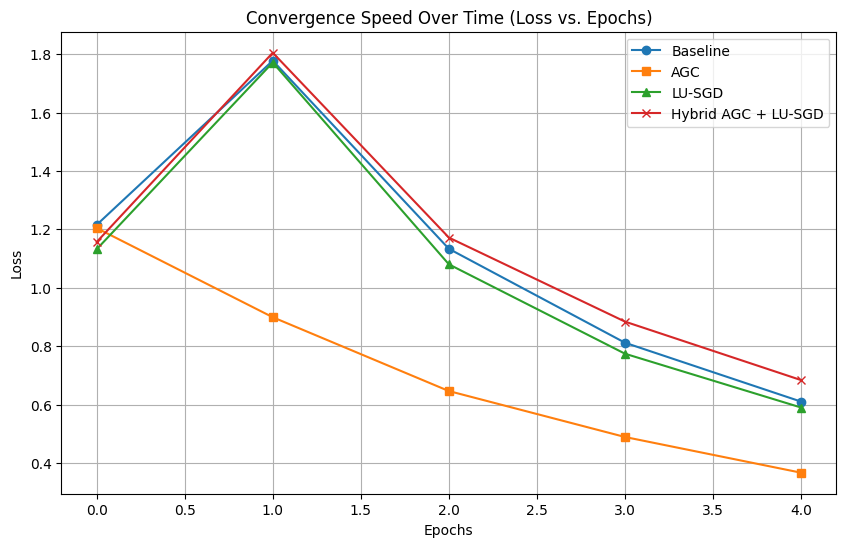

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(baseline_loss)), baseline_loss, label="Baseline", marker='o')
plt.plot(range(len(agc_loss)), agc_loss, label="AGC", marker='s')
plt.plot(range(len(lusgd_loss)), lusgd_loss, label="LU-SGD", marker='^')
plt.plot(range(len(hybrid_loss)), hybrid_loss, label="Hybrid AGC + LU-SGD", marker='x')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Convergence Speed Over Time (Loss vs. Epochs)")
plt.legend()
plt.grid()
plt.show()

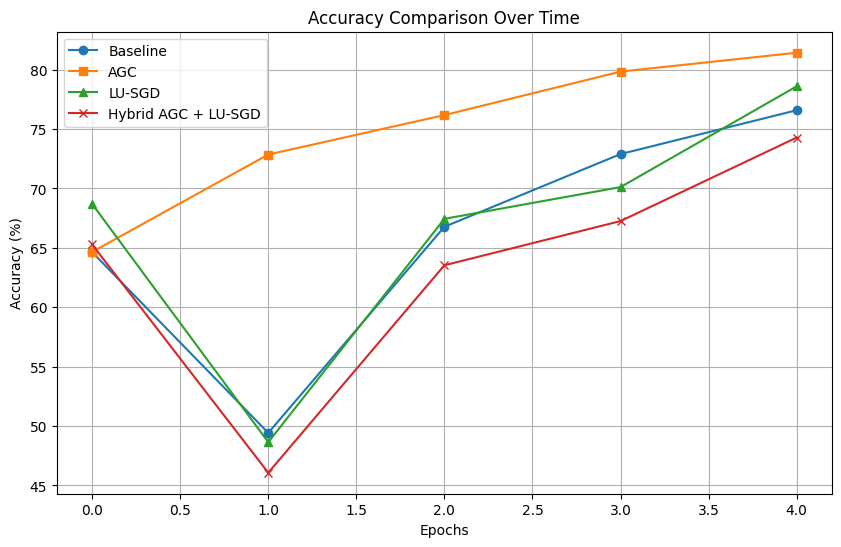

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(baseline_acc)), baseline_acc, label="Baseline", marker='o')
plt.plot(range(len(agc_acc)), agc_acc, label="AGC", marker='s')
plt.plot(range(len(lusgd_acc)), lusgd_acc, label="LU-SGD", marker='^')
plt.plot(range(len(hybrid_acc)), hybrid_acc, label="Hybrid AGC + LU-SGD", marker='x')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Comparison Over Time")
plt.legend()
plt.grid()
plt.show()

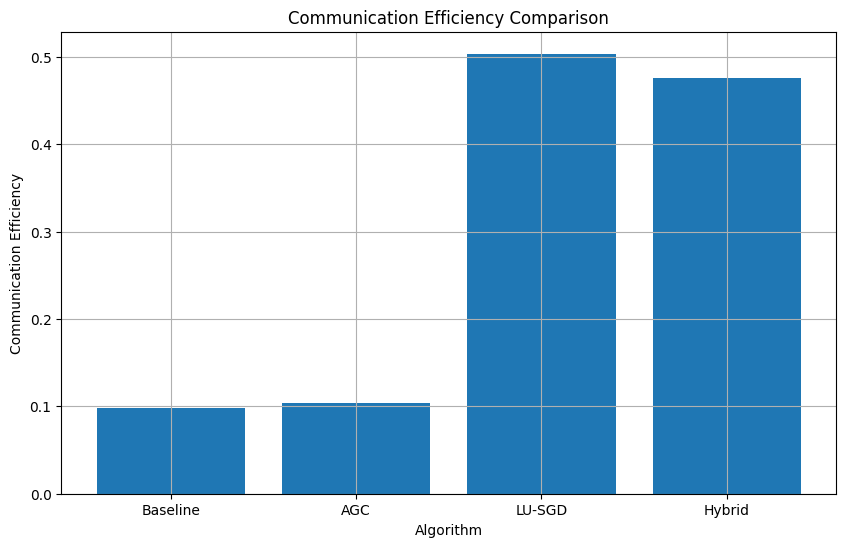

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(["Baseline", "AGC", "LU-SGD", "Hybrid"], [baseline_efficiency, agc_efficiency, lusgd_efficiency, hybrid_efficiency])
plt.xlabel("Algorithm")
plt.ylabel("Communication Efficiency")
plt.title("Communication Efficiency Comparison")
plt.grid()
plt.show()


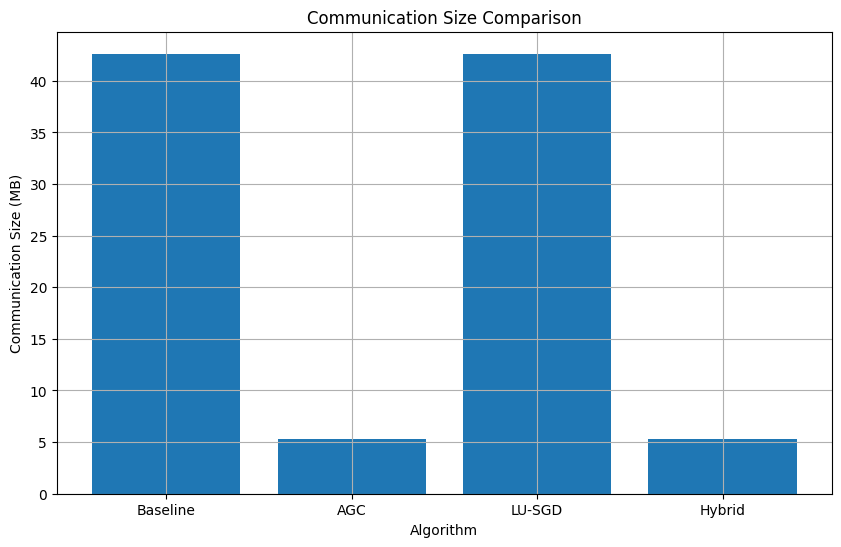

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(["Baseline", "AGC", "LU-SGD", "Hybrid"], [baseline_cost[0], agc_cost[0], lusgd_cost[0], hybrid_cost[0]])
plt.xlabel("Algorithm")
plt.ylabel("Communication Size (MB)")
plt.title("Communication Size Comparison")
plt.grid()
plt.show()